# 📚 Chapter 6: Case Study: Small Molecule Binding to an RNA Target

*This notebook contains the code examples in chapter 6. For readability, the chapter notebooks only contain runnable code blocks and section titles. They omit the rest of the material in the book, i.e., text paragraphs, figures (unless generated as part of one of the code blocks), equations, and pseudocode. I recommend reading the notebooks side-by-side with the book!*

You can work through this notebook locally as well as via Google Colab:
<a target="_blank" href="https://colab.research.google.com/github/nrflynn2/ml-drug-discovery/blob/main/CH06_FLYNN_ML4DD.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

This chapter covers
- An exemplary quantitative structure-activity relationship (QSAR) pipeline for understanding small molecule binding to RNA targets
- Advanced molecular representation and descriptor calculation methods, especially in low data availability contexts
- Representative data splitting with the Kennard-stone algorithm and dimensionality reduction algorithms like principal component analysis (PCA)
- Sequential ensemble learning with gradient boosting
- Advanced methods for model-specific and model-agnostic interpretability

## ⚙️ Part 0: Installation and Setup

**❗️NOTE:** After setting up a local environment, install the required packages via:
`!pip install -r https://raw.githubusercontent.com/nrflynn2/ml-drug-discovery/main/requirements.txt --quiet`

**❗️NOTE:** If running notebook via Colab, be sure to install RDKit via: `!pip install rdkit`

### Import and Setup Packages 

In [2]:
import itertools
import numpy as np
import pandas as pd
import pickle as pkl

import matplotlib as mpl
import matplotlib.pyplot as plt
import py3Dmol
import seaborn as sns
import shap
import xgboost as xgb

from catboost import CatBoostClassifier
from dimorphite_dl import DimorphiteDL
from lightgbm import LGBMClassifier
from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem import AllChem, Draw
from scipy.spatial import distance
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from xgboost import XGBClassifier, XGBRegressor

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

colors = ["#A20025", "#6C8EBF"]
sns.set_palette(sns.color_palette(colors))

/home/nflynn/anaconda3/envs/ml-drug-discovery/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1️⃣ Small Molecule Binding to an RNA Target

### Structure: Computing Descriptors

In [52]:
hiv_tar1 = pd.read_csv(
    "data/CH06_hargrove_data.csv", 
    usecols=["Name", "SMILES", "kon", "koff", "KD", "lnkon", "lnkoff", "lnKD"]
)

**Code for Figure 6.2.** 3D illustration of the drug esomeprazole. We generated 10 conformers of esomeprazole and overlaid them on top of each other, demonstrating the broad spatial range that a molecule’s structure can inhabit.

In [36]:
esomeprazole = Chem.MolFromSmiles('COc1ccc2[n-]c([S@@+]([O-])Cc3ncc(C)c(OC)c3C)nc2c1')
esomeprazole.GetNumConformers()

0

In [37]:
esomeprazole = Chem.AddHs(esomeprazole)

In [38]:
AllChem.EmbedMultipleConfs(esomeprazole, numConfs=10, params=AllChem.ETKDG())
AllChem.AlignMolConformers(esomeprazole, esomeprazole.GetSubstructMatch(Chem.MolFromSmarts('c1[nH]c2ccccc2n1')))

In [39]:
esomeprazole.GetNumConformers()

10

In [48]:
def draw_conf(mol, grid, confId=-1):
    mb = Chem.MolToMolBlock(mol, confId=confId)
    grid.addModel(mb,'sdf')
    grid.setStyle({'stick':{}})
    grid.setBackgroundColor('white')
    grid.zoomTo()

In [54]:
grid = py3Dmol.view(width=500, height=500)
draw_conf(esomeprazole, grid, 0)
grid.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [58]:
grid = py3Dmol.view(width=500, height=500)
for conformer_id in range(10):
    draw_conf(esomeprazole, grid, conformer_id)
grid.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

#### Promoter Search Space

In [16]:
dimorphite_dl = DimorphiteDL(
    min_ph=6.4,
    max_ph=8.4,
    max_variants=128,
    label_states=False,
)

mols = []
tautomer_enumerator = rdMolStandardize.TautomerEnumerator()
ligand2protomers = {}

for ligand_idx, smi in enumerate(hiv_tar1["SMILES"].tolist()):
    mol = Chem.MolFromSmiles(smi)
    mols.append(mol)
    
    protonated_mols = [Chem.MolFromSmiles(protonated_smi) for protonated_smi in dimorphite_dl.protonate(smi)]
    tautomerized_mols = [tautomerized_mol for tautomerized_mol in tautomer_enumerator.Enumerate(mol)]
    
    ligand2protomers[ligand_idx] = protonated_mols + tautomerized_mols

#### Conformer Search Space

In [34]:
def generate_conformers(protomers, numConfs):
    params=AllChem.ETKDGv3()
    params.randomSeed = 0xf00d
    params.numThreads = 4
    protomers_c = []
    protomer2energies = {}

    for protomer_idx, protomer in enumerate(protomers):
        protomer = Chem.AddHs(protomer)
        conformer_ids = AllChem.EmbedMultipleConfs(protomer, numConfs=numConfs, params=params) # Create conformers and store the IDs to access
        UFF_output = AllChem.UFFOptimizeMoleculeConfs(protomer) # Optimize conformers and store convergence and energy results

        min_energy_UFF = min(UFF_output, key=lambda x: x[1])[1]
        energy_threshold = min_energy_UFF + 3

        conformer_energies = []
        for conformer_id, (_, energy) in zip(conformer_ids, UFF_output):
            if energy >= energy_threshold:
                protomer.RemoveConformer(conformer_id)
            conformer_energies.append(energy)

        conformer_ids = [conformer.GetId() for conformer in protomer.GetConformers()]

        protomers_c.append(protomer)
        protomer2energies[protomer_idx] = [conformer_energies[i] for i in conformer_ids]

    return protomers_c, protomer2energies

#### Descriptor Calculation & Aggregation

In [35]:
def compute_boltzmann_weights(protomer2energies):
    protomer2weights = {}
    T = 295
    k_B = 1.987E-3

    den = 0
    for protomer_idx, conformer_energies in protomer2energies.items():
        for conformer_energy in conformer_energies:
            den += np.exp(conformer_energy / (-1 * T * k_B))

    for protomer_idx, conformer_energies in protomer2energies.items():
        protomer2weights[protomer_idx] = [
            np.exp(conformer_energy / (-1 * T * k_B)) / den
            for conformer_energy in conformer_energies
        ]
    
    return protomer2weights

In [60]:
ligand_descs = []
for ligand_idx, protomers in tqdm(ligand2protomers.items()):

    protomers_c, protomer2energies = generate_conformers(protomers, numConfs=10)
    protomer2weights = compute_boltzmann_weights(protomer2energies)
    
    d = []
    for protomer_idx, protomer in enumerate(protomers_c):
        confs = protomer.GetConformers()
        for conf_idx, conf in enumerate(confs):
            rdkit_3D_descs = [
                protomer2weights[protomer_idx][conf_idx] * desc_value
                for desc_name, desc_value in Chem.Descriptors3D.CalcMolDescriptors3D(protomer, confId = conf.GetId()).items()
            ]
            d.append(rdkit_3D_descs)
    
    ligand_descs.append(
        np.array(d).sum(axis=0)
    )

ligand_descs = np.array(ligand_descs)

  0%|          | 0/48 [00:00<?, ?it/s]

100%|██████████| 48/48 [14:37<00:00, 18.29s/it] 


### Activity: Experimentally Measuring Binding Profiles

**Code for Figure 6.5** Mapping each ligand to its equilibrium constant coordinates

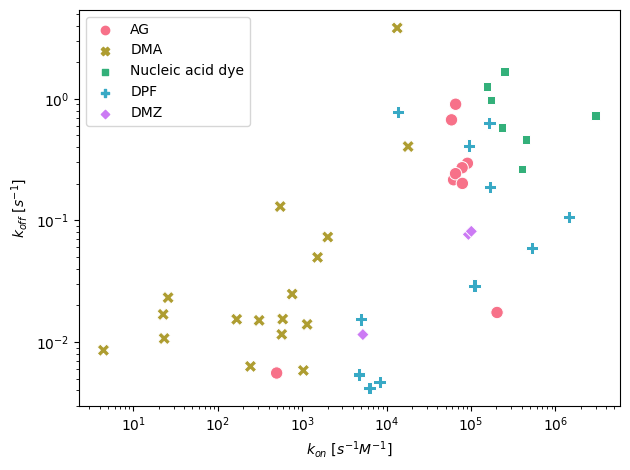

In [11]:
classes = ["AG"]*9 + ["DMA"]*11 + ["Nucleic acid dye"]*2 + ["DPF"]*2 + ["Nucleic acid dye"]*3 + ["DMA"]*6 + ["Nucleic acid dye"] + ["DPF"]*5 + ["Nucleic acid dye"] + ["DPF"]*5 + ["DMZ"]*3
hiv_tar1["class"] = classes

fig, ax = plt.subplots()
ax.set(xscale="log", yscale="log")
g = sns.scatterplot(data=hiv_tar1, x="kon", y="koff", hue="class", style="class", s=80, ax=ax)
g.get_legend().set_title(None)
ax.set_ylabel("$k_{off}$ $[s^{-1}]$")
ax.set_xlabel("$k_{on}$ $[s^{-1}M^{-1}]$")

plt.tight_layout()
plt.savefig('figures/ch06/ligand_target_dist.png', bbox_inches='tight', dpi=600)
plt.savefig('figures/ch06/ligand_target_dist.pdf', bbox_inches='tight', dpi=600);

## 2️⃣ Representative Data Splitting & Dimensionality Reduction

### Data Refinement

**Code for Figure 6.6.** Comparison of the distributions for the raw target values to their log-transformed target values.

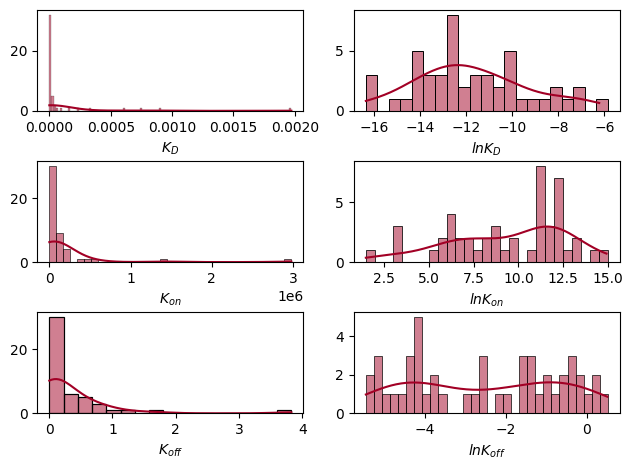

In [9]:
fig, axes = plt.subplots(3, 2)
sns.histplot(data=hiv_tar1, x="KD", ax=axes[0][0], kde=True)
sns.histplot(data=hiv_tar1, x="lnKD", ax=axes[0][1], kde=True, binwidth=0.5)

sns.histplot(data=hiv_tar1, x="kon", ax=axes[1][0], kde=True)
sns.histplot(data=hiv_tar1, x="lnkon", ax=axes[1][1], kde=True, binwidth=0.5)
sns.histplot(data=hiv_tar1, x="koff", ax=axes[2][0], kde=True)
sns.histplot(data=hiv_tar1, x="lnkoff", ax=axes[2][1], kde=True, binwidth=0.2)

axes[0][0].set(xlabel="$K_{D}$", ylabel="")
axes[0][1].set(xlabel="$lnK_{D}$", ylabel="")
axes[1][0].set(xlabel="$K_{on}$", ylabel="")
axes[1][1].set(xlabel="$lnK_{on}$", ylabel="")
axes[2][0].set(xlabel="$K_{off}$", ylabel="")
axes[2][1].set(xlabel="$lnK_{off}$", ylabel="")


plt.tight_layout()
plt.subplots_adjust(hspace=0.5)
plt.savefig('figures/ch06/log_norm_targets.png', bbox_inches='tight', dpi=600)
plt.savefig('figures/ch06/log_norm_targets.pdf', bbox_inches='tight', dpi=600);

In [38]:
hiv_tar1 = pd.read_csv("data/CH06_hargrove_data.csv")

In [39]:
len(hiv_tar1.columns)

443

In [40]:
hiv_tar1_lnkon = hiv_tar1.drop(columns=["Name", "SMILES", "kon", "koff", "KD", "lnkoff", "lnKD"])
hiv_tar1_lnkoff = hiv_tar1.drop(columns=["Name", "SMILES", "kon", "koff", "KD", "lnkon", "lnKD"])
hiv_tar1_lnkd = hiv_tar1.drop(columns=["Name", "SMILES", "kon", "koff", "KD", "lnkon", "lnkoff"])

In [41]:
def refine_data(df, target_col, redundancy_threshold=0.8, correlation_threshold=0.95):
    cols_to_remove = [col for col in df if df[col].value_counts(normalize=True).max() > redundancy_threshold]
    df = df.drop(columns=cols_to_remove)

    corr_matrix = df.drop(columns=[target_col]).corr().abs()
    np.fill_diagonal(corr_matrix.values, 0.)
    cols_to_remove = []
    while corr_matrix.gt(correlation_threshold).any().any():
        # Find the column with the most highly correlated columns
        correlated_cols = corr_matrix.apply(lambda x: x[x > correlation_threshold].index.tolist()).tolist()
        num_correlated = [len(cols) for cols in correlated_cols]
        max_index = np.argmax(num_correlated)

        if num_correlated[max_index] > 2:
            max_col = corr_matrix.columns[max_index]

            # Remove the most highly correlated column
            cols_to_remove.append(max_col)
            corr_matrix = corr_matrix.drop(index=max_col, columns=max_col)
        else:  
            pairwise_correlated_cols = correlated_cols[max_index]
            target_corr = df[pairwise_correlated_cols].corrwith(df[target_col]).abs()

            # Remove the least correlated column to the target
            min_corr_col = target_corr.idxmin()
            cols_to_remove.append(min_corr_col)
            corr_matrix = corr_matrix.drop(index=min_corr_col, columns=min_corr_col)

    return df.drop(columns=cols_to_remove)

In [42]:
hiv_tar1_lnkon = refine_data(hiv_tar1_lnkon, target_col="lnkon")
hiv_tar1_lnkoff = refine_data(hiv_tar1_lnkoff, target_col="lnkoff")
hiv_tar1_lnkd = refine_data(hiv_tar1_lnkd, target_col="lnKD")

In [43]:
print(len(hiv_tar1_lnkon.columns) - 1, len(hiv_tar1_lnkoff.columns) - 1, len(hiv_tar1_lnkd.columns) - 1)

191 192 191


**Code for Figure 6.7** KSA ensures representative sampling from each cluster in this arbitrarily created data set, rather than sampling that is biased towards only one or two clusters.

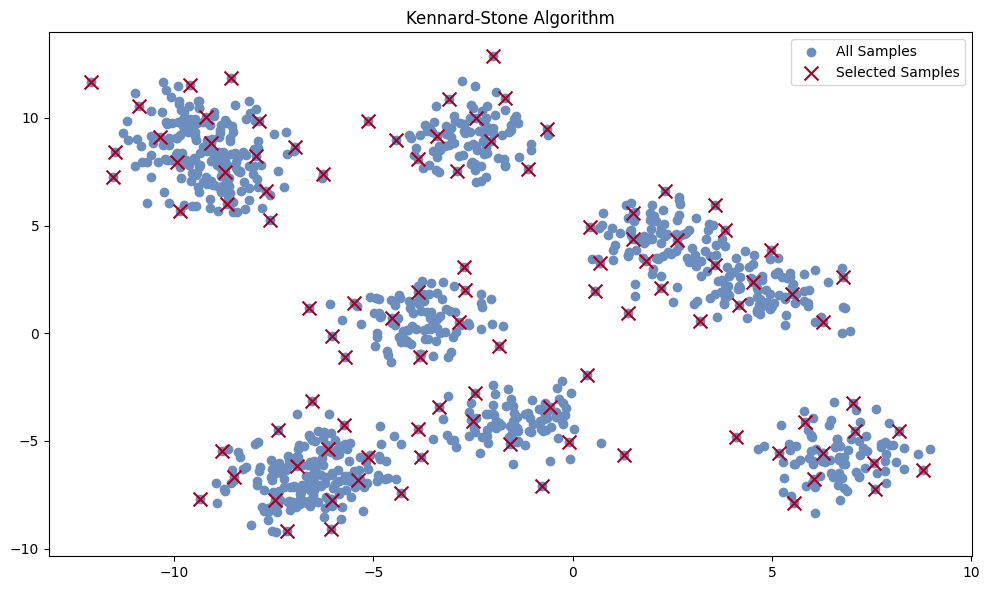

In [ ]:
from scipy.spatial.distance import mahalanobis
from sklearn.datasets import make_blobs

def kennard_stone(X, n_samples):
    """Kennard-Stone algorithm for sample selection. Euclidean distance."""
    n_total_samples = X.shape[0]
    selected_indices = [np.argmax(np.sum(euclidean_distances(X, X), axis=1))]
    remaining_indices = list(range(n_total_samples))
    remaining_indices.remove(selected_indices[0])
    
    for _ in range(1, n_samples):
        dist_matrix = euclidean_distances(X[remaining_indices], X[selected_indices])
        new_index = remaining_indices[np.argmax(np.min(dist_matrix, axis=1))]
        selected_indices.append(new_index)
        remaining_indices.remove(new_index)
    
    return selected_indices

# Generate synthetic data
X, _ = make_blobs(n_samples=1000, centers=10, random_state=42)

# Apply Kennard-Stone algorithm
n_selected_samples = 100
selected_indices = kennard_stone(X, n_selected_samples)
selected_samples = X[selected_indices]

# Visualize the results
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], label='All Samples', color='#6C8EBF')
plt.scatter(selected_samples[:, 0], selected_samples[:, 1], color='#A20025', marker='x', label='Selected Samples', s=100)
plt.title('Kennard-Stone Algorithm')
plt.legend()

plt.tight_layout()
plt.savefig('figures/ch06/KSA_example.png', bbox_inches='tight', dpi=600)
plt.savefig('figures/ch06/KSA_example.pdf', bbox_inches='tight', dpi=600);

### Dimensionality Reduction: Principal Component Analysis

**Code for Figure 6.8** Dimension $x_2$ carries almost no information since the $x_2$-values for each point barely deviate relative to the values along dimension $x_1$. Conversely, the $x_1$ dimension carries a lot of information and removing it would result in a compressed form of the data that is very dissimilar from the original data. 

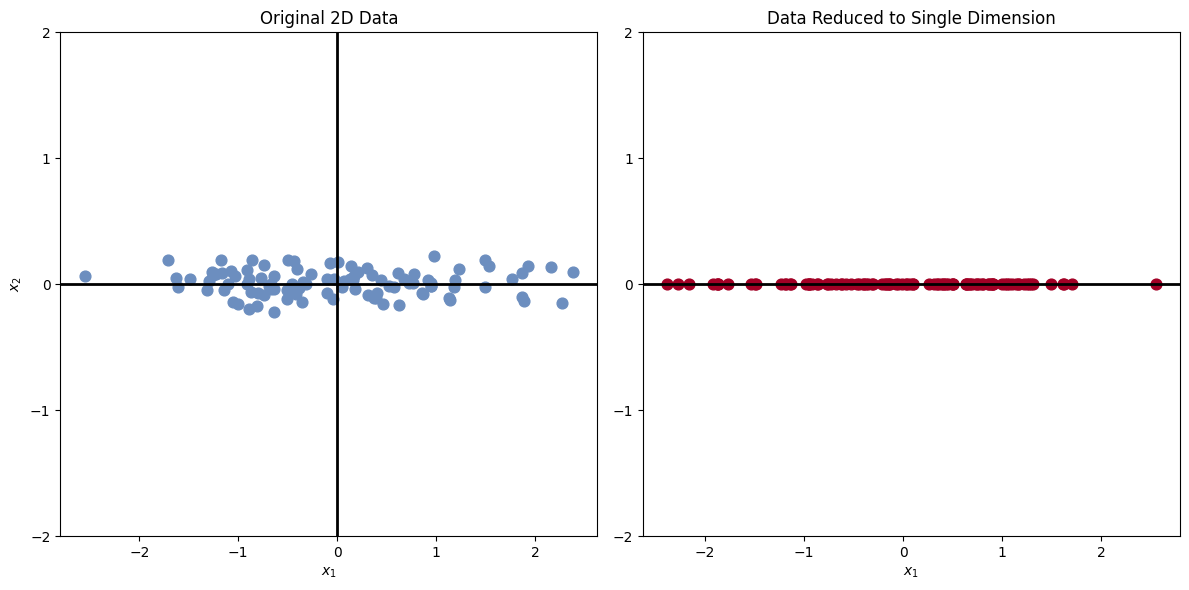

In [ ]:
# Generate 2D data with noise
np.random.seed(0)
X = np.random.randn(100, 2)
X[:, 1] *= 0.1  # Add small amounts of noise to the second dimension

# Plot the original data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], s=60, c="#6C8EBF")
plt.ylim(-2, 2)
plt.title('Original 2D Data')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.yticks(range(-2, 3, 1))
plt.axhline(0, color='black', linewidth=2)
plt.axvline(0, color='black', linewidth=2)

# Perform PCA and reduce to single dimension
pca = PCA(n_components=1)
X_pca = pca.fit_transform(X)

# Plot the data reduced to single dimension
plt.subplot(1, 2, 2)
plt.scatter(X_pca, np.zeros_like(X_pca), s=60, c="#A20025")
plt.ylim(-2, 2)
plt.title('Data Reduced to Single Dimension')
plt.xlabel('$x_1$')
plt.yticks(range(-2, 3, 1))
plt.axhline(0, color='black', linewidth=2)

plt.tight_layout()
plt.savefig('figures/ch06/2D_to_1D.png', bbox_inches='tight', dpi=600)
plt.savefig('figures/ch06/2D_to_1D.pdf', bbox_inches='tight', dpi=600);

In [111]:
pca = PCA(n_components=48)
pca.fit(hiv_tar1_X)

PCA(n_components=48)

In [112]:
eigenvalues = pca.explained_variance_
n_components_eigenvalue = np.argmax(eigenvalues < 1)
print(f"Number of components selected based on eigenvalue criterion: {n_components_eigenvalue}")

cumsum = np.cumsum(pca.explained_variance_ratio_)
n_components_proportion= np.argmax(cumsum >= 0.99) + 1
print(f"Number of components selected based on proportion of variance explained criterion: {n_components_proportion}")

#pca = PCA(n_components=0.95)
#hiv_tar1_lnkd_X_2D = pca.fit_transform(hiv_tar1_lnkd_X)
#pca.n_components_

Number of components selected based on eigenvalue criterion: 22
Number of components selected based on proportion of variance explained criterion: 32


**Code for Figure 6.10.** Optimal number of components to retain, $k$, for three different criteria. The blue diamond markers where the optimal $k$ would be chosen for each plot. Note that the scree plot criterion is more subjective and values of $k$ between 4 and 9, inclusive, could be argued for and selected.

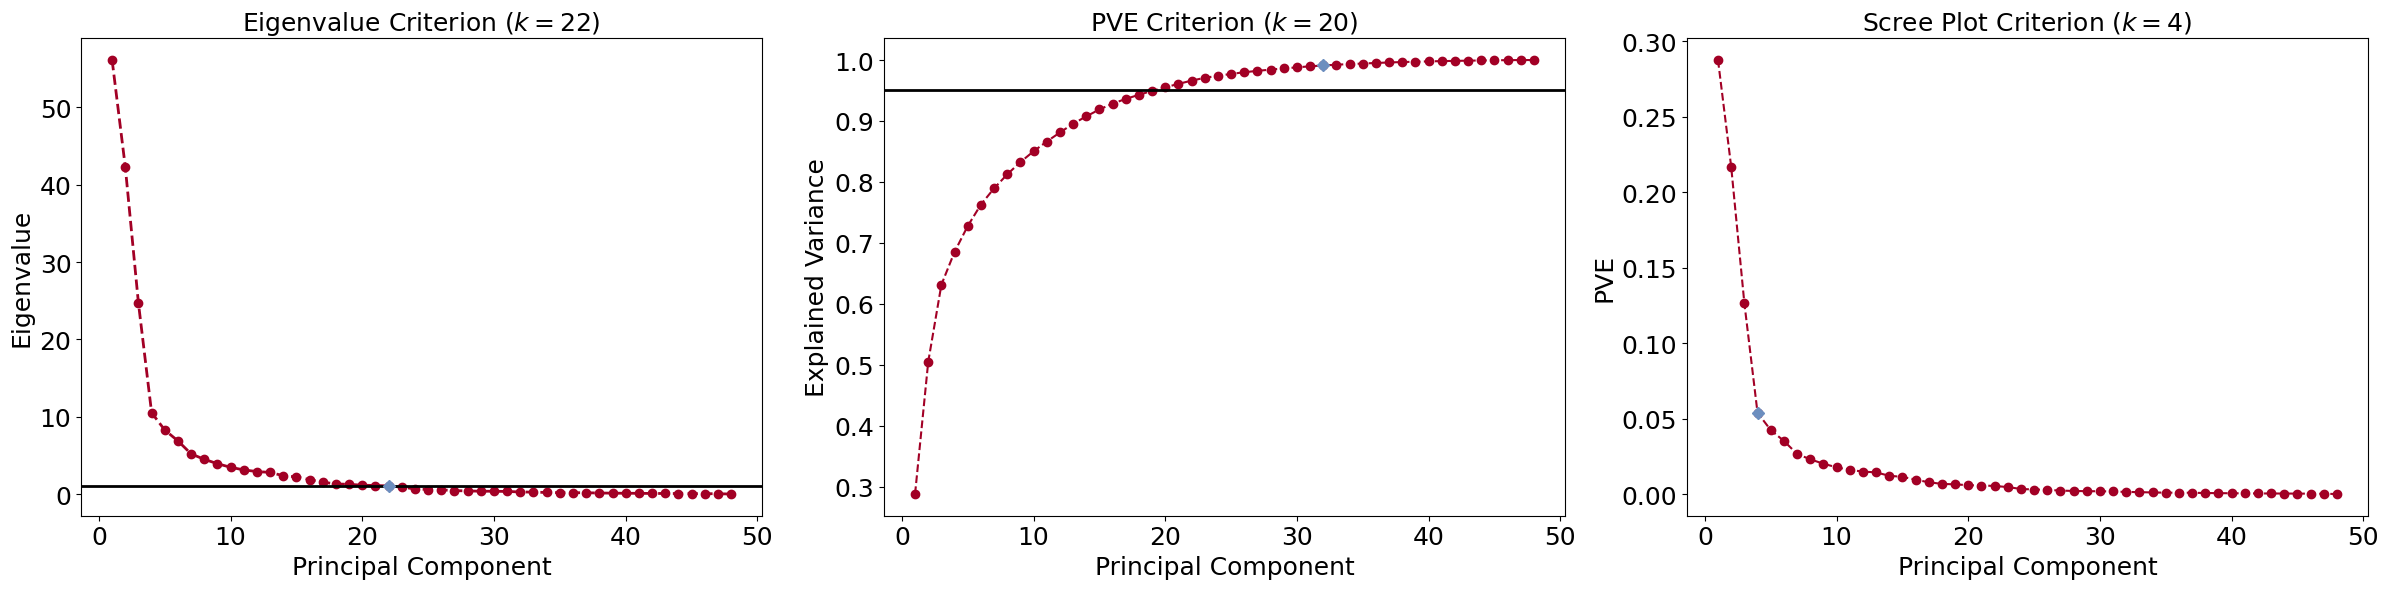

In [114]:
plt.figure(figsize=(24, 6))
plt.subplot(1, 3, 1)
plt.plot(np.arange(1, 49), eigenvalues, marker='o', linestyle='--', linewidth=2)
plt.xlabel('Principal Component', fontsize=18)
plt.ylabel('Eigenvalue', fontsize=18)
plt.title('Eigenvalue Criterion ($k = 22$)', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.axhline(1, color="black", linewidth=2)
plt.plot(22, eigenvalues[21], "D", color="#6C8EBF")

plt.subplot(1, 3, 2)
plt.plot(np.arange(1, 49), cumsum, marker='o', linestyle='--')
plt.plot(32, cumsum[31], "D", color="#6C8EBF")
plt.xlabel('Principal Component', fontsize=18)
plt.ylabel('Explained Variance', fontsize=18)
plt.title('PVE Criterion ($k = 20$)', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.axhline(0.99, color="black", linewidth=2)

plt.subplot(1, 3, 3)
plt.plot(np.arange(1, 49), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.plot(4, pca.explained_variance_ratio_[3], "D", color="#6C8EBF")
plt.xlabel('Principal Component', fontsize=18)
plt.ylabel('PVE', fontsize=18)
plt.title('Scree Plot Criterion ($k = 4$)', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.tight_layout()
plt.savefig('figures/ch06/choosing_k_pca.png', bbox_inches='tight', dpi=600)
plt.savefig('figures/ch06/choosing_k_pca.pdf', bbox_inches='tight', dpi=600);

In [63]:
n_components_scree = 4
print(f"Number of components selected based on Scree plot criterion: {n_components_scree}")

Number of components selected based on Scree plot criterion: 4


In [44]:
sc = StandardScaler() 

pca = PCA(n_components=0.99)
hiv_tar1_lnkd_X = sc.fit_transform(hiv_tar1_lnkd.drop(columns=["lnKD"]))
hiv_tar1_lnkd_X_DR = pca.fit_transform(hiv_tar1_lnkd_X)
lnkd_explained_variance = pca.explained_variance_ratio_
print(pca.n_components_)

hiv_tar1_lnkoff_X = sc.fit_transform(hiv_tar1_lnkoff.drop(columns=["lnkoff"]))
hiv_tar1_lnkoff_X_DR = pca.fit_transform(hiv_tar1_lnkoff_X)
lnkoff_explained_variance = pca.explained_variance_ratio_
print(pca.n_components_)

hiv_tar1_lnkon_X = sc.fit_transform(hiv_tar1_lnkon.drop(columns=["lnkon"]))
hiv_tar1_lnkon_X_DR = pca.fit_transform(hiv_tar1_lnkon_X)
lnkon_explained_variance = pca.explained_variance_ratio_
print(pca.n_components_)

32
32
32


In [45]:
def kennard_stone(X, n_samples):
    """Kennard-Stone algorithm for sample selection. Mahalanobis distance."""
    n_total_samples = X.shape[0]
    selected_indices = [np.argmax(np.sum(distance.cdist(X, [X.mean(axis=0)], 'mahalanobis', VI=np.linalg.inv(np.cov(X.T))), axis=1))]
    remaining_indices = list(range(n_total_samples))
    remaining_indices.remove(selected_indices[0])
    
    for _ in range(1, n_samples):
        mahalanobis_dist = distance.cdist(X[remaining_indices], [X[selected_indices[-1]]], 'mahalanobis', VI=np.linalg.inv(np.cov(X.T))).ravel()
        new_index = remaining_indices[np.argmax(mahalanobis_dist)]
        selected_indices.append(new_index)
        remaining_indices.remove(new_index)
    
    return selected_indices

**Code for Figure 6.11.** (First plot) The train and test set molecules distributed in 2D chemical space. (Second plot) Distribution of the target variables after representative data splitting.

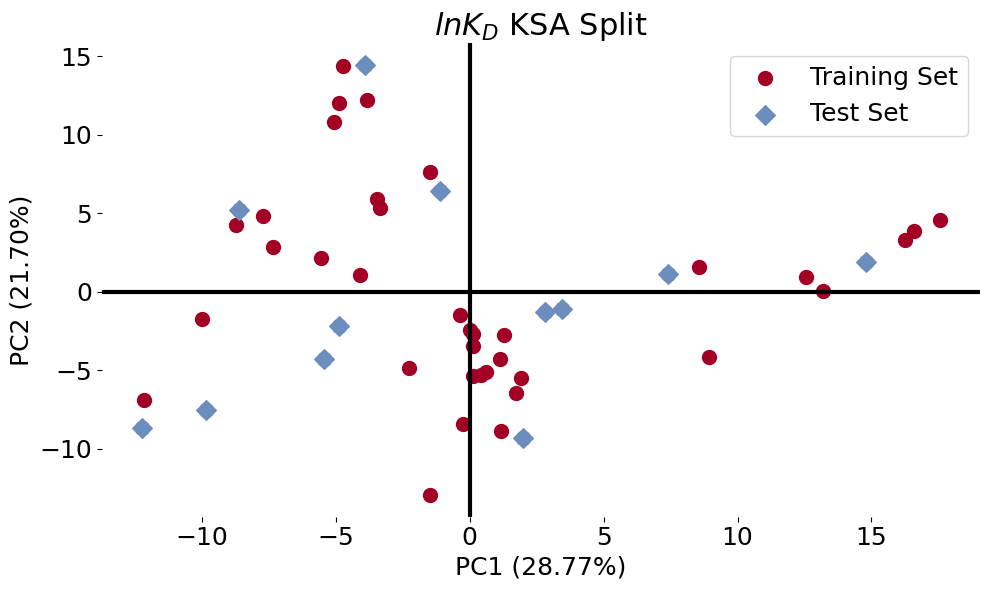

In [ ]:
# Visualize the results
plt.figure(figsize=(10, 6))
plt.scatter(hiv_tar1_lnkd_X_DR[:, 0], hiv_tar1_lnkd_X_DR[:, 1], label='Training Set', color='#A20025', s=100)
plt.scatter(selected_samples[:, 0], selected_samples[:, 1], color='#6C8EBF', marker="D", label='Test Set', s=100)
plt.title('$lnK_D$ KSA Split', fontsize=22)
plt.legend(fontsize=18)
plt.box(False)
plt.xlabel(f"PC1 ({lnkd_explained_variance[0]:.2%})", fontsize=18)
plt.ylabel(f"PC2 ({lnkd_explained_variance[1]:.2%})", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.axvline(linewidth=3, color='black')
plt.axhline(linewidth=3, color='black')

plt.tight_layout()
plt.savefig('figures/ch06/lnkd_KSA_split.png', bbox_inches='tight', dpi=600)
plt.savefig('figures/ch06/lnkd_KSA_split.pdf', bbox_inches='tight', dpi=600);

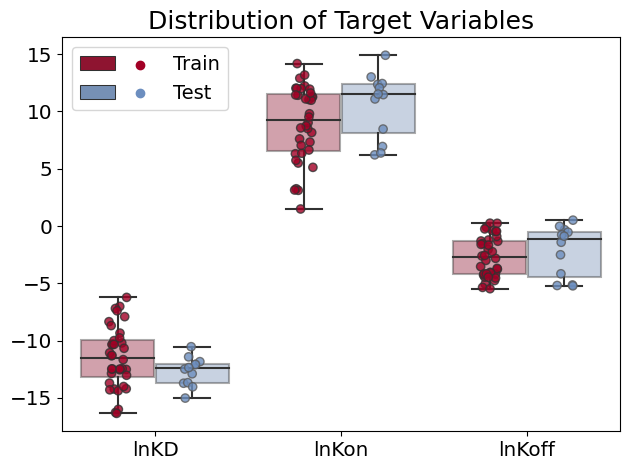

In [ ]:
from matplotlib.legend_handler import HandlerTuple

boxplot_y = lnkd_y_train.tolist() + lnkd_y_test.tolist() + lnkon_y_train.tolist() + lnkon_y_test.tolist() + lnkoff_y_train.tolist() + lnkoff_y_test.tolist()
boxplot_hue = ["Train"] * 36 + ["Test"] * 12 + ["Train"] * 36 + ["Test"] * 12 + ["Train"] * 36 + ["Test"] * 12
boxplot_x = ["lnKD"] * 48 + ["lnKon"] * 48 + ["lnKoff"] * 48

ax = sns.boxplot(x=boxplot_x, y=boxplot_y, hue=boxplot_hue, boxprops={'alpha': 0.4}, showfliers=False)
sns.stripplot(x=boxplot_x, y=boxplot_y, hue=boxplot_hue, dodge=True, ax=ax, s=6, linewidth=1, alpha=.8)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=[(handles[0], handles[2]), (handles[1], handles[3])],
          labels=['Train', 'Test'],
          loc='upper left', handlelength=4,
          handler_map={tuple: HandlerTuple(ndivide=None)}, fontsize=14)
ax.xaxis.set_tick_params(labelsize='x-large')
ax.yaxis.set_tick_params(labelsize='x-large')

plt.title('Distribution of Target Variables', fontsize=18)
plt.tight_layout()
plt.savefig('figures/ch06/dist_response_vars.png', bbox_inches='tight', dpi=600)
plt.savefig('figures/ch06/dist_response_vars.pdf', bbox_inches='tight', dpi=600);

In [46]:
selected_indices_lnkd = kennard_stone(hiv_tar1_lnkd_X_DR, 12)
selected_samples_lnkd = hiv_tar1_lnkd_X_DR[selected_indices_lnkd]

selected_indices_lnkoff = kennard_stone(hiv_tar1_lnkoff_X_DR, 12)
selected_samples_lnkoff = hiv_tar1_lnkoff_X_DR[selected_indices_lnkoff]

selected_indices_lnkon = kennard_stone(hiv_tar1_lnkon_X_DR, 12)
selected_samples_lnkon = hiv_tar1_lnkon_X_DR[selected_indices_lnkon]
print(selected_indices_lnkd)
print(selected_indices_lnkoff)
print(selected_indices_lnkon)

[25, 3, 21, 46, 39, 26, 24, 47, 9, 5, 10, 42]
[25, 3, 21, 46, 39, 26, 24, 42, 10, 5, 9, 47]
[25, 3, 21, 46, 39, 26, 24, 47, 9, 5, 10, 42]


In [47]:
mask = hiv_tar1_lnkd.index.isin(selected_indices_lnkd)
mask

array([False, False, False,  True, False,  True, False, False, False,
        True,  True, False, False, False, False, False, False, False,
       False, False, False,  True, False, False,  True,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False,  True, False, False,
       False,  True,  True])

In [48]:
hiv_tar1.Name[mask]

3         Streptomycin
5           Gentamycin
9                DMA-1
10             DMA-148
21        Mitoxantrone
24          Furamidine
25    Ethidium Bromide
26             H-33258
39     Acridine Orange
42              DPF p5
46           Bernil p8
47          Bernil p13
Name: Name, dtype: object

In [49]:
test_idxs_paper = [
    1, 5, 9, 12, 18, 23, 26, 31, 33, 35, 42, 47,
]
mask = hiv_tar1_lnkd["lnKD"].index.isin(test_idxs_paper)
mask

array([False,  True, False, False, False,  True, False, False, False,
        True, False, False,  True, False, False, False, False, False,
        True, False, False, False, False,  True, False, False,  True,
       False, False, False, False,  True, False,  True, False,  True,
       False, False, False, False, False, False,  True, False, False,
       False, False,  True])

In [50]:
hiv_tar1.Name[mask]

1                    Paromomycin
5                     Gentamycin
9                          DMA-1
12                       DMA-164
18                       DMA-193
23                        DPF p1
26                       H-33258
31                        DCC-3q
33    Thiazole Orange (tosylate)
35                        DPF m9
42                        DPF p5
47                    Bernil p13
Name: Name, dtype: object

## 3️⃣ QSAR Modeling: Mapping Descriptors to Measurements

### Exemplary QSAR Modeling Workflow

In [87]:
def mask_train_test_split(X, y, test_idxs):
    mask = y.index.isin(test_idxs)
    sc = StandardScaler() 
    X_train = sc.fit_transform(X[~mask])
    X_test = sc.transform(X[mask])

    return X_train, X_test, y[~mask], y[mask]

def lasso_feature_selection(X_train, X_test, y_train, y_test):

    # Define the parameter grid for alpha values
    param_grid = {'alpha': np.logspace(2, -6, num=1000)}

    # Create a Lasso regressor
    lasso = Lasso()

    # Perform grid search with 5-fold cross-validation
    grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Get the best alpha and best model
    best_alpha = grid_search.best_params_['alpha']
    best_model = grid_search.best_estimator_

    # Evaluate the best model on the test set
    y_pred = best_model.predict(X_test)
    r2 = r2_score(y_test, y_pred)

    print(f"Best alpha: {best_alpha}")
    print(f"Best R2: {r2}")

    selected_features = np.where(best_model.coef_ != 0)[0]
    return best_alpha, selected_features

def compute_feature_pvals(model, X, y):
    # Calculate the standard errors of the coefficients
    n = len(y)
    p = X.shape[1]
    y_pred = model.predict(X)
    residuals = y - y_pred
    mse = np.sum(residuals**2) / (n - p - 1)
    var_b = mse * (np.linalg.inv(np.dot(X.T, X)).diagonal())
    std_err = np.sqrt(var_b)

    # Calculate the t-statistics and p-values
    t_stat = model.coef_ / std_err
    p_values = 2 * (1 - stats.t.cdf(np.abs(t_stat), n - p - 1))

    return np.round(p_values, 3)

def MLR_exhaustive_search(X_train, X_test, y_train, y_test, selected_features, threshold=0.7, max_descs=7):

    best_score = -np.inf
    best_model = None
    best_p_values = None
    best_features = None

    X_train = X_train[:, selected_features]
    X_test = X_test[:, selected_features]

    # Generate all possible combinations of features
    for r in range(2, max_descs+1):    #Minimum 2 features, maximum 7 features, Toolis
        for feature_combination in itertools.combinations(range(X_train.shape[1]), r):
            # Train a linear regression model
            model = LinearRegression()
            model.fit(X_train[:, feature_combination], y_train)

            # Evaluate the model
            y_train_pred = model.predict(X_train[:, feature_combination])
            y_test_pred = model.predict(X_test[:, feature_combination])

            r2_train = r2_score(y_train, y_train_pred)
            q2_test = r2_score(y_test, y_test_pred)

            if r2_train <= threshold or q2_test <= threshold:
                continue

            p_values = compute_feature_pvals(model, X_train[:, feature_combination], y_train)
            # Update best model if current model is better
            if q2_test > best_score and np.all(p_values < 0.05):
                best_score = q2_test
                best_model = model
                best_features = feature_combination
                best_p_values = p_values

    best_selected_features = [selected_features[feature] for feature in best_features]

    print(f"Best Q2: {best_score}")
    print(f"Best Features: {best_features}")
    return best_model, best_selected_features, best_score, best_p_values

def paper_MLR_workflow(X, y, test_idxs, threshold=0.7, max_descs=7):

    X_train, X_test, y_train, y_test = mask_train_test_split(X, y, test_idxs)

    print("Begin Lasso Feature Selection")
    best_alpha, selected_features = lasso_feature_selection(X_train, X_test, y_train, y_test)

    print("Screen Performative MLR Models")
    return MLR_exhaustive_search(X_train, X_test, y_train, y_test, selected_features, threshold, max_descs)

In [90]:
best_model_kon, best_features_kon, best_score_kon, best_p_values_kon = paper_MLR_workflow(hiv_tar1_lnkon.drop(columns=["lnkon"]), hiv_tar1_lnkon["lnkon"], test_idxs_paper)
print(f"QSAR Feature Names: {hiv_tar1_lnkon.drop(columns=['lnkon']).columns[[best_features_kon]]}")
print(f"QSAR Coefficients: {best_model_kon.coef_}")
print(f"QSAR Intercept: {best_model_kon.intercept_}")

Begin Lasso Feature Selection


/home/nflynn/anaconda3/envs/ml-drug-discovery/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.819e-02, tolerance: 3.237e-02
  model = cd_fast.enet_coordinate_descent(
/home/nflynn/anaconda3/envs/ml-drug-discovery/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.239e-02, tolerance: 3.237e-02
  model = cd_fast.enet_coordinate_descent(
/home/nflynn/anaconda3/envs/ml-drug-discovery/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check t

Best alpha: 0.07959777002314986
Best R2: 0.2798556352064372
Screen Performative MLR Models
Best Q2: 0.7924263002555423
Best Features: (4, 8, 9, 15, 17, 18, 20)
QSAR Feature Names: [['E_oop' 'GCUT_PEOE_0' 'h_pKb' 'vsa_other' 'vsurf_DD23' 'vsurf_DW12'
  'vsurf_IW3']]
QSAR Coefficients: [-0.87498913 -0.66337576  0.56893965 -1.72977477  0.50321844  0.5693903
 -1.29009861]
QSAR Intercept: 9.242536363277775


/tmp/ipykernel_787/2936987212.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  print(f"QSAR Feature Names: {hiv_tar1_lnkon.drop(columns=['lnkon']).columns[[best_features_kon]]}")


In [89]:
best_model_koff, best_features_koff, best_score_koff, best_p_values_koff = paper_MLR_workflow(hiv_tar1_lnkoff.drop(columns=["lnkoff"]), hiv_tar1_lnkoff["lnkoff"], test_idxs_paper, threshold=0.6)
print(f"QSAR Feature Names: {hiv_tar1_lnkoff.drop(columns=['lnkoff']).columns[[best_features_koff]]}")
print(f"QSAR Coefficients: {best_model_koff.coef_}")
print(f"QSAR Intercept: {best_model_koff.intercept_}")

Begin Lasso Feature Selection


/home/nflynn/anaconda3/envs/ml-drug-discovery/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.175e-02, tolerance: 1.017e-02
  model = cd_fast.enet_coordinate_descent(
/home/nflynn/anaconda3/envs/ml-drug-discovery/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.764e-02, tolerance: 1.017e-02
  model = cd_fast.enet_coordinate_descent(
/home/nflynn/anaconda3/envs/ml-drug-discovery/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check t

Best alpha: 0.21150728248687947
Best R2: 0.31235980012788156
Screen Performative MLR Models
Best Q2: 0.6710946455661693
Best Features: (1, 2, 8)
QSAR Feature Names: [['a_base' 'a_nN' 'vsurf_DD13']]
QSAR Coefficients: [-0.80040191 -1.04135819  0.55291156]
QSAR Intercept: -2.665462416750001


/tmp/ipykernel_787/2693621373.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  print(f"QSAR Feature Names: {hiv_tar1_lnkoff.drop(columns=['lnkoff']).columns[[best_features_koff]]}")


In [91]:
best_model_kd, best_features_kd, best_score_kd, best_p_values_kd = paper_MLR_workflow(hiv_tar1_lnkd.drop(columns=["lnKD"]), hiv_tar1_lnkd["lnKD"], test_idxs_paper, max_descs=4)
print(f"QSAR Feature Names: {hiv_tar1_lnkd.drop(columns=['lnKD']).columns[[best_features_kd]]}")
print(f"QSAR Coefficients: {best_model_kd.coef_}")
print(f"QSAR Intercept: {best_model_kd.intercept_}")

Begin Lasso Feature Selection


/home/nflynn/anaconda3/envs/ml-drug-discovery/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.954e-02, tolerance: 1.250e-02
  model = cd_fast.enet_coordinate_descent(
/home/nflynn/anaconda3/envs/ml-drug-discovery/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.131e-02, tolerance: 1.250e-02
  model = cd_fast.enet_coordinate_descent(
/home/nflynn/anaconda3/envs/ml-drug-discovery/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check t

Best alpha: 0.0016566059589499151
Best R2: 0.5118954098941262
Screen Performative MLR Models
Best Q2: 0.8819034465687525
Best Features: (16, 19, 40, 41)
QSAR Feature Names: [['E_sol' 'GCUT_PEOE_0' 'vsurf_EWmin1' 'vsurf_ID4']]
QSAR Coefficients: [ 1.3918995   0.60491835 -0.67376962  0.94664921]
QSAR Intercept: -11.799190567666665


/tmp/ipykernel_787/3631512588.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  print(f"QSAR Feature Names: {hiv_tar1_lnkd.drop(columns=['lnKD']).columns[[best_features_kd]]}")


**Code for Figure 6.12.** Williams plot for applicability domain assessment of $lnK_{off}$. Bounds are defined as a standardized residual greater or less than $+3$ or $-3$, respectively, or a leverage that is greater than $3(p + 1)/n$, where $p$ is the number of descriptors in the QSAR model and $n$ is the number of data points.

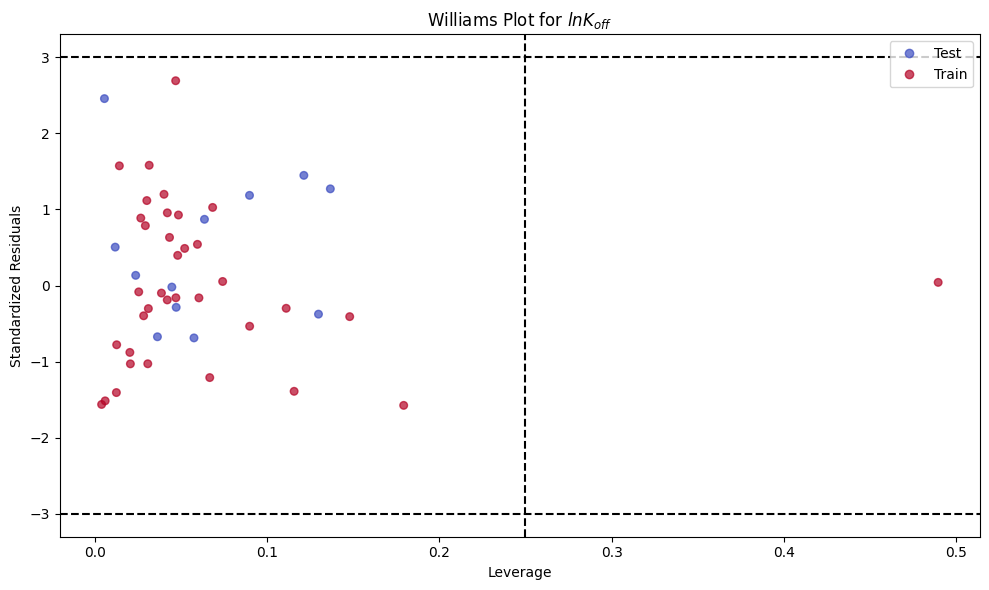

In [77]:
X = hiv_tar1_lnkoff_X[:, best_features_koff]
y = hiv_tar1_lnkoff["lnkoff"]

y_pred = best_model_koff.predict(X)
residuals = y - y_pred
leverage = np.diag(X.dot(np.linalg.pinv(X.T.dot(X)).dot(X.T)))
mse = np.mean(residuals**2)
standardized_residuals = residuals / np.sqrt(mse * (1 - leverage))

test_pts = [(i not in test_idxs_paper) for i in range(48)]

# Plot Williams plot
plt.figure(figsize=(10, 6))
scp = plt.scatter(leverage, standardized_residuals, c=test_pts, cmap='coolwarm', alpha=0.7, s=30)
plt.axhline(y=3, color='black', linestyle='--')
plt.axhline(y=-3, color='black', linestyle='--')
plt.axvline(x=(3*(len(best_features_koff) + 1))/len(y), color='black', linestyle='--')
plt.xlabel('Leverage')
plt.ylabel('Standardized Residuals')
plt.title('Williams Plot for $lnK_{off}$')
plt.legend(handles=[scp.legend_elements()[0][0], scp.legend_elements()[0][-1]], labels=['Test', 'Train'], loc='upper right')
plt.tight_layout()
plt.savefig('figures/ch06/williams.png', bbox_inches='tight', dpi=600)
plt.savefig('figures/ch06/williams.pdf', bbox_inches='tight', dpi=600);

In [36]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Assuming X is your feature matrix and y is your target variable
X_train, X_test, y_train, y_test = mask_train_test_split(hiv_tar1_lnkd_X, hiv_tar1_lnkd["lnKD"], test_idxs_paper)

# Define hyperparameter grids
xgb_param_grid = {
    'n_estimators': [100, 250, 500],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 4, 5, 7],
    #'subsample': [0.2, 0.6, 1.0],
    #'booster': ['dart', 'gbtree'],
    #'eta': [0.01, 0.1, 0.5],
    #'lambda': [0.0, 0.5, 1.0, 2.0]

}

"""
lgbm_param_grid = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7]
}

catboost_param_grid = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7]
}
"""

# Perform grid search for each model
models = [
    (XGBRegressor(), xgb_param_grid),
    #(LGBMRegressor(), lgbm_param_grid),
    #(CatBoostRegressor(silent=True), catboost_param_grid)
]

best_model = None
best_score = -np.inf
best_model_name = None

for model, param_grid in models:
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    
    y_pred = grid_search.best_estimator_.predict(X_test)
    score = r2_score(y_test, y_pred)
    
    print(f"Model: {model.__class__.__name__}, Best Parameters: {grid_search.best_params_}, R-squared: {score}")
    
    if score > best_score:
        best_score = score
        best_model = grid_search.best_estimator_
        best_model_name = model.__class__.__name__

print(f"Best model: {best_model_name}, Best R-squared: {best_score}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits


Model: XGBRegressor, Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}, R-squared: 0.7874645786897482
Best model: XGBRegressor, Best R-squared: 0.7874645786897482


In [86]:

model = XGBRegressor()
#model = LGBMRegressor(),
#model = CatBoostRegressor(silent=True)
from sklearn.ensemble import HistGradientBoostingRegressor
X_train, X_test, y_train, y_test = lnkon_X_train, lnkon_X_test, lnkon_y_train, lnkon_y_test
#model = HistGradientBoostingRegressor()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
score = r2_score(y_test, y_pred)

## 4️⃣ Gradient Boosting Machines

### Informing the RNA-Binding Chemical Space

In [95]:
# Read in ROBIN RNA binders and BindingDB protein binders
df_ROBIN_RNA = pd.read_csv("data/Mordred_ROBIN_RNA_Binder_3D.csv")
df_BindingDB = pd.read_csv("data/Mordred_BindingDB_3D.csv")

# Remove the name column
df_ROBIN_RNA = df_ROBIN_RNA.drop('name', axis=1)
df_BindingDB = df_BindingDB.drop('name', axis=1)

# Delete duplicate rows that might still remain in the feature sets
df_ROBIN_RNA.drop_duplicates(keep="first", inplace=True)
df_BindingDB.drop_duplicates(keep="first", inplace=True)

# Add libary names to the dataframes
df_ROBIN_RNA["Library"] = "RNA Binding"
df_BindingDB["Library"] = "Protein Binding" 

# Concat the dataframes and convert feature columns to numeric
df_all_2 = pd.concat([df_ROBIN_RNA, df_BindingDB])
df_all_2_columns = df_all_2.columns.tolist()[:-1]
df_all_2[df_all_2_columns] = df_all_2[df_all_2_columns].apply(pd.to_numeric, errors='coerce')

print("Done 1")

Done 1


In [84]:
# Delete columns that have feature values missing in more than 40% of rows
df_all_2 = df_all_2.dropna(thresh=df_all_2.shape[0]*0.6, axis=1)

print("Done 2")

# Replace missing and infinity values by median of each column
df_all_2.replace([np.inf, -np.inf], np.nan, inplace=True)
df_all_2 = df_all_2.fillna(df_all_2.median(numeric_only=True))

# Reset the index
df_all_2 = df_all_2.reset_index(drop=True)

df_all_2.to_csv("data/CH06_ROBIN_RNA_vs_BindingDB.csv", index=False)

KeyboardInterrupt: 

In [85]:
df_all_2 = pd.read_csv("data/CH06_ROBIN_RNA_vs_BindingDB.csv")
df_all_2

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2,Library
0,8.134854,7.731889,0,0,13.152542,2.292456,4.584911,13.152542,1.195686,3.294652,...,40.991311,212.978926,11.209417,152,14,52.0,58.0,5.194444,2.472222,RNA Binding
1,12.825381,10.895567,0,0,21.829826,2.405852,4.811703,21.829826,1.284107,3.747219,...,49.542495,233.068808,8.323886,528,25,84.0,97.0,5.805556,3.916667,RNA Binding
2,12.756432,10.434514,0,0,21.445449,2.430978,4.677100,21.445449,1.340341,3.730823,...,62.610127,210.079313,8.079974,435,22,86.0,101.0,4.055556,3.472222,RNA Binding
3,12.756432,10.386039,0,0,21.352964,2.421292,4.681454,21.352964,1.334560,3.730817,...,62.599178,210.079313,8.079974,441,22,86.0,101.0,4.055556,3.472222,RNA Binding
4,9.968445,8.888322,0,0,16.522521,2.394745,4.663162,16.522521,1.270963,3.500706,...,58.124309,193.056135,8.044006,247,16,66.0,76.0,4.194444,2.944444,RNA Binding
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79676,50.572365,33.803322,1,1,80.382517,2.463082,4.920462,80.382517,1.275913,5.084455,...,116.455462,918.252733,8.424337,20600,108,350.0,414.0,20.798611,13.125000,Protein Binding
79677,48.840314,33.349757,1,1,78.668310,2.461681,4.916747,78.668310,1.289644,5.052189,...,115.990083,869.290498,8.048986,18809,102,336.0,398.0,18.986111,12.875000,Protein Binding
79678,52.266458,33.232614,0,2,84.944901,2.459249,4.911151,84.944901,1.306845,5.118811,...,118.547785,988.275972,8.235633,23446,111,360.0,427.0,19.097222,13.708333,Protein Binding
79679,55.082955,36.129435,0,2,88.799904,2.488147,4.945299,88.799904,1.305881,5.186933,...,129.984451,963.392009,7.585764,25999,118,384.0,461.0,20.180556,14.208333,Protein Binding


In [86]:
# Data preparation for ML by conversion to float numpy arrays

# Prepare the features
X_all_2 = df_all_2.values[:, :-1]
X_all_2 = X_all_2.astype('float64')
print("Shape of the X_all_2 matrix:")
print(X_all_2.shape)
print()

# Prepare the labels
y_all_2 = df_all_2.values[:, -1]
y_all_2 = y_all_2.tolist()
y_all_2 = [1 if x == "RNA Binding" else x for x in y_all_2]
y_all_2 = [0 if x == "Protein Binding" else x for x in y_all_2]
y_all_2 = np.array(y_all_2)
y_all_2 = y_all_2.astype(float)
print("Shape of the y_all_2 labels array:")
print(y_all_2.shape)

Shape of the X_all_2 matrix:
(79681, 1670)

Shape of the y_all_2 labels array:
(79681,)


In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score
from sklearn.model_selection import StratifiedKFold

models = [
    XGBClassifier(),
    #LGBMClassifier()
    #CatBoostClassifier(silent=True)
]

best_model = None
best_score = -np.inf
best_model_name = None

for model in models:
    cv = StratifiedKFold(10, random_state=5, shuffle=True)
    scores = []
    for idx, (train, test) in enumerate(cv.split(X_all_2, y_all_2)):
        
        X_train, X_test, y_train, y_test = X_all_2[train], X_all_2[test], y_all_2[train], y_all_2[test]
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_test)[:, 1]
        scores.append(average_precision_score(y_test, y_pred))
        print(f"Fold {idx+1} AUPRC: {scores[idx]}")

    score = sum(scores) / len(scores)
    print(f"Model: {model.__class__.__name__}, 10-Fold AUPRC AVG: {score}")
    if score > best_score:
        best_score = score
        best_model = model
        best_model_name = model.__class__.__name__

print(f"Best model: {best_model_name}, Best AUPRC: {best_score}")

Fold 1 AUPRC: 0.7528434869285345
Fold 2 AUPRC: 0.8060312649474171
Fold 3 AUPRC: 0.7682849360062513
Fold 4 AUPRC: 0.7659896573090511
Fold 5 AUPRC: 0.783063103086412
Fold 6 AUPRC: 0.7879549417546798
Fold 7 AUPRC: 0.822378863330657
Fold 8 AUPRC: 0.8245227288346241
Fold 9 AUPRC: 0.7914148083177851
Fold 10 AUPRC: 0.8026469399539733
Model: XGBClassifier, 10-Fold AUPRC AVG: 0.7905130730469385
Best model: XGBClassifier, Best AUPRC: 0.7905130730469385


In [59]:
sc_xgb = StandardScaler()
X_all_2_sc = sc_xgb.fit_transform(X_all_2)
model = XGBClassifier().fit(X_all_2_sc, y_all_2)
model.get_booster().feature_names = df_all_2.drop(columns=['Library']).columns.tolist()

**Code for Figure 6.14.** Feature importance of our XGBoost model across gain, coverage, and frequency metrics.

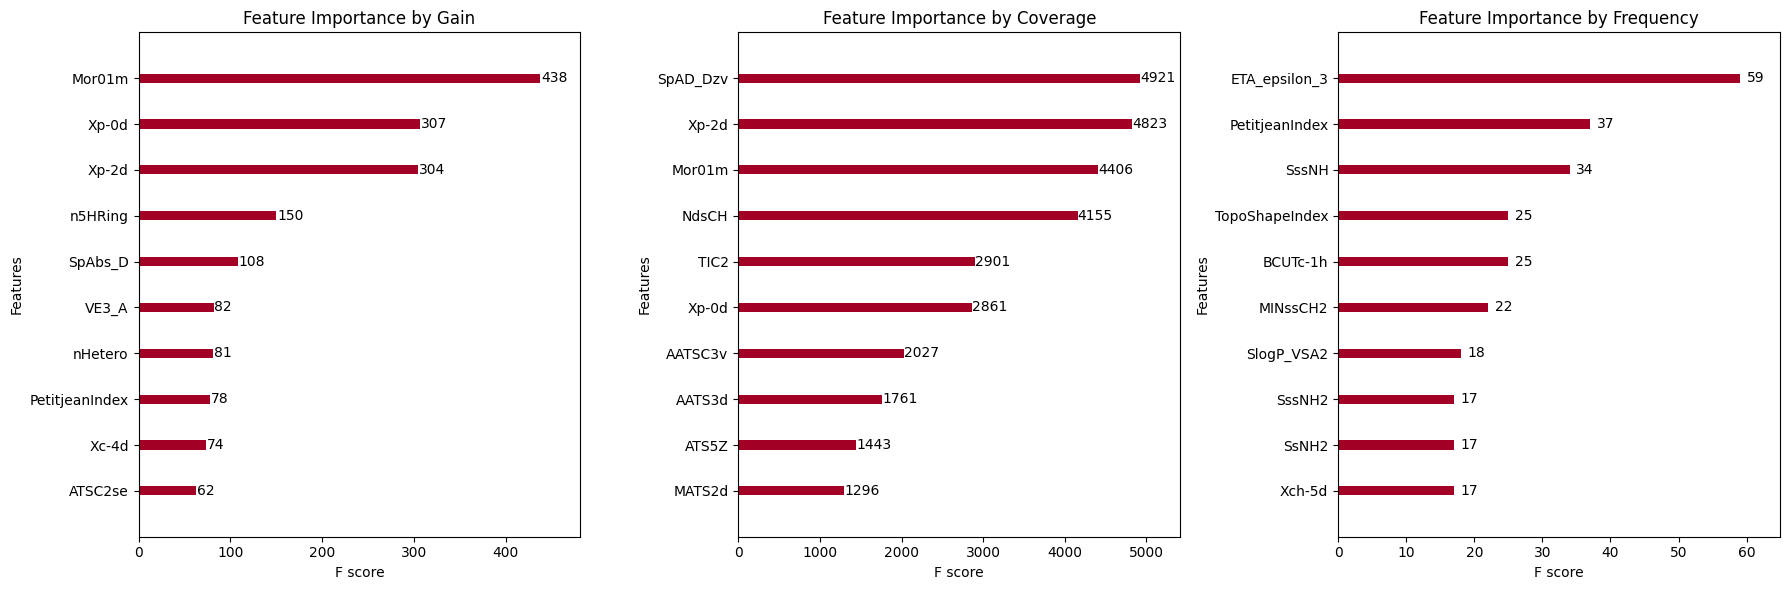

In [74]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
format_args = {"max_num_features":10, "grid":False, "values_format":"{v:.0f}"}
# Gain
xgb.plot_importance(model, importance_type='gain', ax=axs[0], **format_args)
axs[0].set_title('Feature Importance by Gain')

# Coverage
xgb.plot_importance(model, importance_type='cover', ax=axs[1], **format_args)
axs[1].set_title('Feature Importance by Coverage')

# Frequency
xgb.plot_importance(model, importance_type='weight', ax=axs[2], **format_args)
axs[2].set_title('Feature Importance by Frequency')

plt.tight_layout()
plt.savefig('figures/ch06/xgb_plot_importances.png', bbox_inches='tight', dpi=600)
plt.savefig('figures/ch06/xgb_plot_importances.pdf', bbox_inches='tight', dpi=600);

### Model-agnostic Interpretation

**Code for Figure 6.14** Descriptors with partial derivatives greater than 0.01 for the first RNA binder from the ROBIN data set.

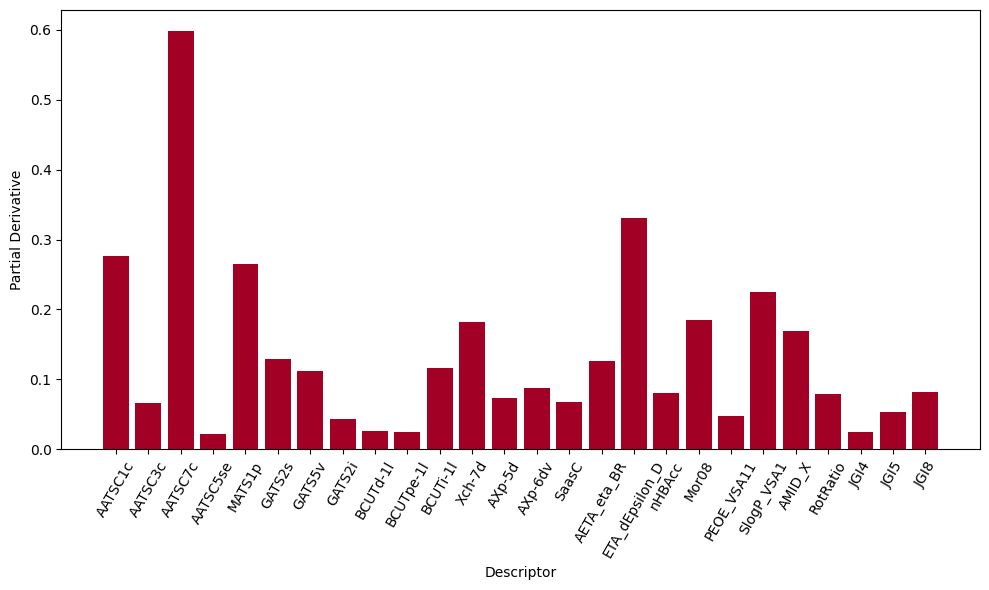

In [121]:
def partial_derivative(model, X, feature_idx):
    delta = 5e-2
    X_plus = X.copy()
    X_plus[:, feature_idx] += delta
    y_pred_plus = model.predict_proba(X_plus)[:, 1]
    X_minus = X.copy()
    X_minus[:, feature_idx] -= delta
    y_pred_minus = model.predict_proba(X_minus)[:, 1]
    partial_derivative = (y_pred_plus - y_pred_minus) / (2 * delta)
    return partial_derivative

# Calculate partial derivatives for each feature
partial_derivatives = np.zeros(X_all_2.shape[1])
for i in range(X_all_2.shape[1]):
    partial_derivatives[i] = partial_derivative(best_model, X_all_2[:1], i)

feature_names = df_all_2.drop(columns=['Library']).columns[partial_derivatives > 1e-2]
partial_derivatives = partial_derivatives[partial_derivatives > 1e-2]

plt.figure(figsize=(10, 6))
plt.bar(range(len(partial_derivatives)), partial_derivatives, tick_label=feature_names)
plt.xlabel('Descriptor')
plt.ylabel('Partial Derivative')
plt.xticks(rotation=60)
#plt.title('Partial Derivative Analysis')
plt.tight_layout()
plt.savefig('figures/ch06/partial_derivatives_analysis.png', bbox_inches='tight', dpi=600)
plt.savefig('figures/ch06/partial_derivatives_analysis.pdf', bbox_inches='tight', dpi=600);

In [87]:
model = XGBClassifier().fit(X_all_2, y_all_2)

In [88]:
explainer = shap.TreeExplainer(model, data=None)

In [109]:
shap_values = explainer.shap_values(X_all_2[:5000])

In [128]:
shap.summary_plot(shap_values, X_all_2[:5000], max_display=10, feature_names=df_all_2.drop(columns=['Library']).columns, show=False)
plt.title("Beeswarm Plot")
plt.savefig('figures/ch06/shap_beeswarmplot.png', bbox_inches='tight', dpi=600)
plt.savefig('figures/ch06/shap_beeswarmplot.pdf', bbox_inches='tight', dpi=600);
plt.close()

In [111]:
shap_values_exp = shap.Explanation(
    values=shap_values, 
    base_values=explainer.expected_value, 
    data=X_all_2[:5000], 
    feature_names=df_all_2.drop(columns=['Library']).columns
)

In [113]:
binder_type = df_all_2['Library'].tolist()[:5000]

**Code for Figure 6.16.** SHAP visualizations to support global interpretation of descriptor importance (beeswarm plot), comparison of binder cohorts across important descriptors (bar plot), local interpretation of descriptor importance for a single compound (waterfall plot), and the effect of a single descriptor on model predictions (scatter plot).

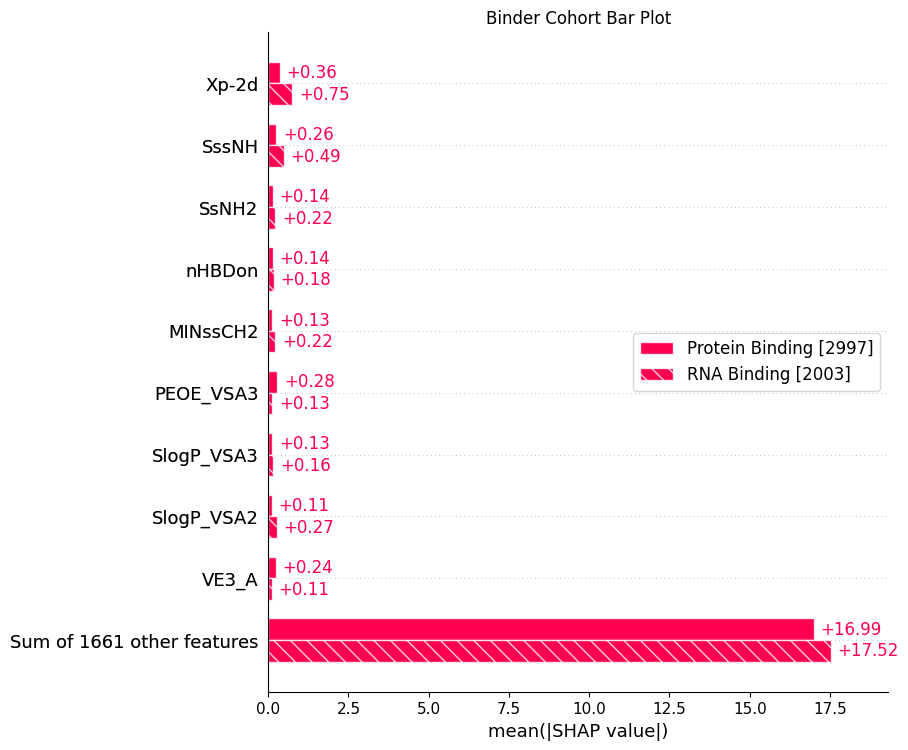

In [121]:
shap.plots.bar(shap_values_exp.cohorts(binder_type).abs.mean(0), show=False)
plt.title("Binder Cohort Bar Plot")
plt.savefig('figures/ch06/shap_barplot.png', bbox_inches='tight', dpi=600)
plt.savefig('figures/ch06/shap_barplot.pdf', bbox_inches='tight', dpi=600);

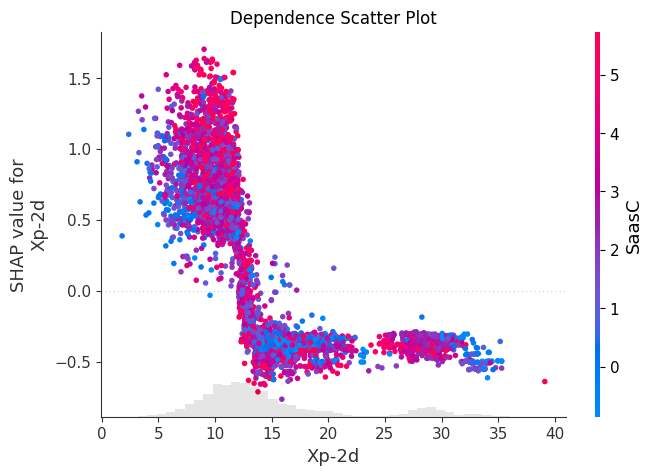

In [120]:
shap.plots.scatter(shap_values_exp[:, shap_values_exp.abs.mean(0).argsort[-1]], color=shap_values_exp, show=False)
plt.title("Dependence Scatter Plot")
plt.savefig('figures/ch06/shap_scatterplot.png', bbox_inches='tight', dpi=600)
plt.savefig('figures/ch06/shap_scatterplot.pdf', bbox_inches='tight', dpi=600);

In [ ]:
shap.plots.waterfall(shap_values_exp[1], max_display=10, show=False)
plt.title("Waterfall Plot")
plt.savefig('figures/ch06/shap_waterfall.png', bbox_inches='tight', dpi=600)
plt.savefig('figures/ch06/shap_waterfall.pdf', bbox_inches='tight', dpi=600);
plt.close()

In [103]:
shap_values_exp

.values =
array([[-7.9281945e-06, -8.4829945e-03,  0.0000000e+00, ...,
         0.0000000e+00,  1.5062637e-02,  2.1154367e-04],
       [-7.9281945e-06,  1.6255751e-02,  0.0000000e+00, ...,
         0.0000000e+00,  8.8623114e-02,  2.1154367e-04],
       [-7.9281945e-06,  4.0302947e-02,  0.0000000e+00, ...,
         0.0000000e+00,  2.2100916e-02,  2.1154367e-04],
       ...,
       [-7.9281945e-06,  7.8172069e-03,  0.0000000e+00, ...,
         0.0000000e+00, -1.1180520e-02, -5.7419291e-04],
       [-1.2351493e-05,  3.3883892e-02,  0.0000000e+00, ...,
         0.0000000e+00,  3.8915817e-03, -5.7419291e-04],
       [-7.9281945e-06,  3.0440725e-02,  0.0000000e+00, ...,
         0.0000000e+00, -4.9528297e-02,  1.0112001e-03]], dtype=float32)

.base_values =
-4.288576

.data =
array([[  8.13485356,   7.73188928,   0.        , ...,  58.        ,
          5.19444444,   2.47222222],
       [ 12.82538132,  10.89556735,   0.        , ...,  97.        ,
          5.80555556,   3.91666667],
       